# TVB co-simulation with Reduced Wong-Wang model

We demonstrate a multiscale simulation <br> of a reduced Wong-Wang model [3] <br> using TVB [1, 2] for brain region modelled at coarse scale, <br> and NEST [4] for regions modelled as <br> networks of spiking neural populations.

In [1]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_nest.config import *
config = Config()
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'

from tvb_nest.plot.plotter import Plotter
plotter = Plotter(config)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2019-12-02 19:04:10,748 - INFO - numexpr.utils - NumExpr defaulting to 6 threads.


/home/docker/packages/tvb-library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2019-12-02 19:04:11,594 - DEBUG - matplotlib - $HOME=/home/docker
2019-12-02 19:04:11,596 - DEBUG - matplotlib - CONFIGDIR=/home/docker/.config/matplotlib
2019-12-02 19:04:11,601 - DEBUG - matplotlib - matplotlib data path: /usr/share/matplotlib/mpl-data
2019-12-02 19:04:11,602 - DEBUG - matplotlib - loaded rc file /etc/matplotlibrc
2019-12-02 19:04:11,605 - DEBUG - matplotlib - matplotlib version 3.0.2
2019-12-02 19:04:11,605 - DEBUG - matplotlib - interactive is False
2019-12-02 19:04:11,607 - DEBUG - matplotlib - platform is linux
2019-12-02 19:04:11,608 - DEBUG - matplotlib - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_colle

2019-12-02 19:04:11,662 - DEBUG - matplotlib - CACHEDIR=/home/docker/.cache/matplotlib
2019-12-02 19:04:11,665 - DEBUG - matplotlib.font_manager - Using fontManager instance from /home/docker/.cache/matplotlib/fontlist-v300.json
2019-12-02 19:04:11,787 - DEBUG - matplotlib.pyplot - Loaded backend agg version unknown.
2019-12-02 19:04:12,384 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.datatypes.projections.ProjectionMatrix.conductances = Attr(field_type=<class 'dict'>, default={'air': 0.0, 'skin': 1.0, 'skull': 0.01, 'brain': 1.0}, required=False)
2019-12-02 19:04:12,410 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.datatypes.time_series.TimeSeries.labels_dimensions = Attr(field_type=<class 'dict'>, default={}, required=True)
2019-12-02 19:04:12,488 - DEBUG - matplotlib.pyplot - Loaded backend module://ipykernel.pylab

## Load structural data <br> (minimally a TVB connectivity)

2019-12-02 19:04:12,558 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a66133198>
2019-12-02 19:04:12,559 - DEBUG - matplotlib.colorbar - Using auto colorbar locator on colorbar
2019-12-02 19:04:12,560 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a66133198>
2019-12-02 19:04:12,561 - DEBUG - matplotlib.colorbar - Setting pcolormesh
2019-12-02 19:04:12,657 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:12,658 - DEBUG - matplotlib.axes._base - not adjusting title pos because title was already placed manually: 1.050000
2019-12-02 19:04:12,681 - DEBUG - matplotlib.font_manager - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-12-02 19:04:12,940 - DEBUG - matplotlib.font_manager - findfont: Matching :family=sans

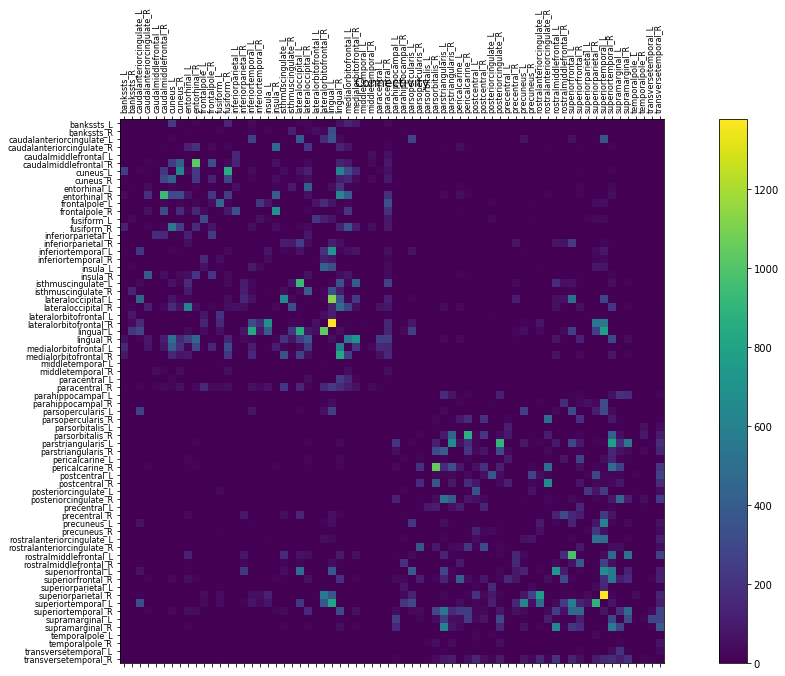

2019-12-02 19:04:14,627 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a65fb4978>
2019-12-02 19:04:14,628 - DEBUG - matplotlib.colorbar - Using auto colorbar locator on colorbar
2019-12-02 19:04:14,629 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a65fb4978>
2019-12-02 19:04:14,630 - DEBUG - matplotlib.colorbar - Setting pcolormesh
2019-12-02 19:04:14,779 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:14,780 - DEBUG - matplotlib.axes._base - not adjusting title pos because title was already placed manually: 1.050000
2019-12-02 19:04:15,040 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:15,131 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:15,132 - DEBUG - matplotlib.axes._base - title position was updated manually, not adjusting
2019-12-02 19:04:15,371 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:15,

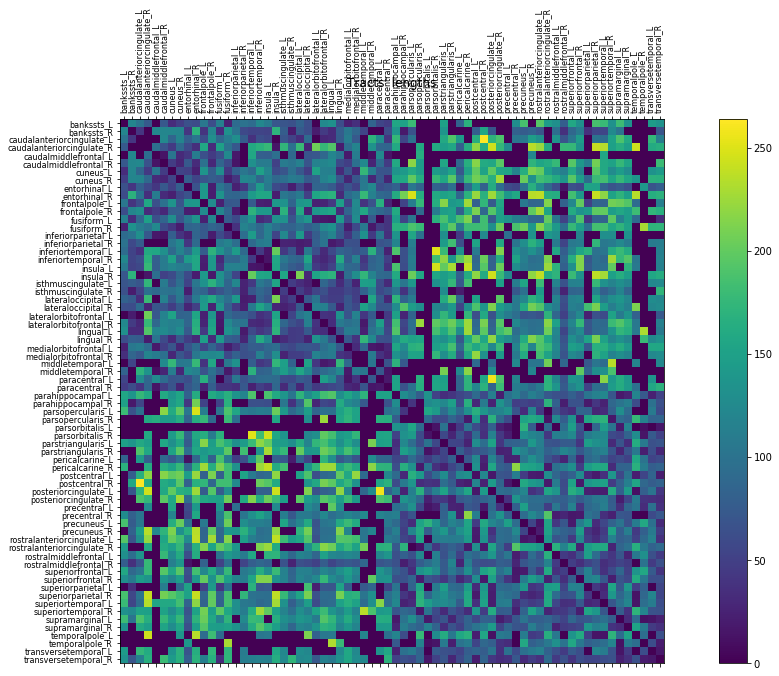

(<Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a613a3080>)

In [2]:
from tvb.datatypes.connectivity import Connectivity
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
connectivity.configure()
plotter.plot_tvb_connectivity(connectivity)

## Prepare TVB simulator <br> (model, integrator, monitors etc)

In [3]:
from tvb_nest.simulator_tvb.simulator import Simulator
from tvb_nest.simulator_tvb.models.reduced_wong_wang_exc_io_inh_i \
    import ReducedWongWangExcIOInhI
from tvb.simulator.monitors import Raw  # , Bold, EEG

# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = Simulator()
simulator.model = ReducedWongWangExcIOInhI()
    
simulator.connectivity = connectivity
simulator.integrator.dt = \
    float(int(np.round(simulator.integrator.dt / 
                       config.nest.NEST_MIN_DT))) * config.nest.NEST_MIN_DT
simulator.integrator.noise.nsig = np.array([0.001])

# Some extra monitors for neuroimaging measures:
mon_raw = Raw(period=simulator.integrator.dt)
# mon_bold = Bold(period=2000.)
# mon_eeg = EEG(period=simulator.integrator.dt)
simulator.monitors = (mon_raw, )  # mon_bold, mon_eeg

2019-12-02 19:04:17,363 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
2019-12-02 19:04:17,367 - WARNING - tvb.traits - default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
2019-12-02 19:04:17,367 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required

2019-12-02 19:04:20,492 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.Generic2dOscillator.state_variable_range = Final(field_type=<class 'dict'>, default={'V': array([-2.,  4.]), 'W': array([-6.,  6.])}, required=True)
2019-12-02 19:04:20,661 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.Kuramoto.state_variable_range = Final(field_type=<class 'dict'>, default={'theta': array([0.        , 6.28318531])}, required=True)
2019-12-02 19:04:20,663 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.oscillator.SupHopf.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-5.,  5.]), 'y': array([-5.,  5.])}, required=True)
2019-12-02 19:04:20,796 - WARNING

## Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [4]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []  # the indices of fine scale regions modeled with NEST
# We model parahippocampal cortices (left and right) with NEST
for id in range(number_of_regions):
    if simulator.connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_ids.append(id)
        
from tvb_nest.simulator_nest.builders.models.red_ww_exc_io_inh_i \
    import RedWWExcIOInhIBuilder

# Build a NEST network model with the corresponding builder
# Using all default parameters for this example
nest_model_builder = \
    RedWWExcIOInhIBuilder(simulator, nest_nodes_ids, config=config)
nest_model_builder.populations_order = 100

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# # Connection weights between the distinct populations:
# # Inhibition to excitation feedback inhibition
# # that could result from Feedback Inhibition Control
# # (see Deco, Ponce-Alvarez et al, J. of Neuroscience, 2014)
# nest_model_builder.w_ee = 1.4
# nest_model_builder.J_i = 1.0

# # Common order of neurons' number per population:
# nest_model_builder.populations_order = 100
# # Populations' configurations
# nest_model_builder.populations = [
#     {"label": "E", "model": nest_model_builder.default_population["model"],
#      "params": {}, "scale": 1, "nodes": None},  # None means "all"
#     {"label": "I", "model": nest_model_builder.default_population["model"],
#      "params": {}, "scale": 0.7, "nodes": None}  # None means "all"
#                                  ]

# # Within region-node connections
# nest_model_builder.populations_connections = [
#     {"source": "E", "target": "E",  # # E -> E This is a self-connection for population "E"
#      "model": nest_model_builder.default_populations_connection["model"],
#      "params": nest_model_builder.default_populations_connection["params"],
#      "weight": nest_model_builder.w_ee, 
#      "delay": nest_model_builder.default_populations_connection["delay"],
#      "receptor_type": 0, "nodes": None},  # None means "all"
#     {"source": "E", "target": "I",  # E -> I
#      "model": nest_model_builder.default_populations_connection["model"],
#      "params": nest_model_builder.default_populations_connection["params"],
#      "weight": 1.0, 
#      "delay": nest_model_builder.default_populations_connection["delay"],
#      "receptor_type": 0, "nodes": None},  # None means "all"
#     {"source": "I", "target": "E",  # I -> E
#      "model": nest_model_builder.default_populations_connection["model"],
#      "params": nest_model_builder.default_populations_connection["params"],
#      "weight": -nest_model_builder.J_i, 
#      "delay": nest_model_builder.default_populations_connection["delay"],
#      "receptor_type": 0, "nodes": None},  # None means "all"
#     {"source": "I", "target": "I",  # I -> I This is a nmbd-connection for population "I"
#      "model": nest_model_builder.default_populations_connection["model"],
#      "params": nest_model_builder.default_populations_connection["params"],
#      "weight": -1.0, 
#      "delay": nest_model_builder.default_populations_connection["delay"],
#      "receptor_type": 0, "nodes": None},  # None means "all"
#                                             ]

# # Among/Between region-node connections
# # Given that only the AMPA population of one region-node couples to
# # all populations of another region-node,
# # we need only one connection type
# nest_model_builder.nodes_connections = [
#     {"source": "E", "target": ["E", "I"],
#      "model": nest_model_builder.default_nodes_connection["model"],
#      "params": nest_model_builder.default_nodes_connection["params"],
#      "weight": 1.0,  # weight scaling the TVB connectivity weight
#      # additional delay to the one of TVB connectivity:
#      "delay": nest_model_builder.default_nodes_connection["delay"],  
#      # Each region emits spikes in its own port:
#      "receptor_type": 0, "source_nodes": None, "target_nodes": None}  # None means "all"
#                                         ]

# # Creating  devices to be able to observe NEST activity:
# # Labels have to be different
# nest_model_builder.output_devices = []
# connections = OrderedDict({})
# #          label <- target population
# connections["E"] = "E"
# connections["I"] = "I"
# nest_model_builder.output_devices.append(
#     {"model": "spike_detector", "params": {},
#      "connections": connections, "nodes": None})  # None means all here
# connections = OrderedDict({})
# connections["Excitatory"] = "E"
# connections["Inhibitory"] = "I"
# params = dict(nest_model_builder.config.nest.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"])
# params["interval"] = nest_model_builder.monitor_period
# nest_model_builder.output_devices.append(
#     {"model": "multimeter", "params": params,
#      "connections": connections, "nodes": None})  # None means all here

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

nest_network = nest_model_builder.build_nest_network()

2019-12-02 19:04:21,726 - INFO - tvb_nest.simulator_nest.builders.base - Loading a NEST instance...
2019-12-02 19:04:21,726 - INFO - tvb_nest.simulator_nest.builders.base - Loading a NEST instance...
2019-12-02 19:04:21,729 - INFO - tvb_nest.simulator_nest.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2019-12-02 19:04:21,729 - INFO - tvb_nest.simulator_nest.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2019-12-02 19:04:21,731 - INFO - tvb_nest.simulator_nest.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2019-12-02 19:04:21,731 - INFO - tvb_nest.simulator_nest.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2019-12-02 19:04:21,733 - INFO - tvb_nest.simulator_nest.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2019-12-02 19:04:21,733 - INFO - tvb_nest.simulator_nest.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc

2019-12-02 19:04:22,567 - WARNING - tvb_nest.simulator_nest.builders.base - Coupling spiking neurons with delay = 0.025000 <= NEST integration step = 0.025 is not possible!
Setting delay equal to NEST integration step!
2019-12-02 19:04:22,572 - WARNING - tvb_nest.simulator_nest.builders.base - Coupling spiking neurons with delay = 0.025000 <= NEST integration step = 0.025 is not possible!
Setting delay equal to NEST integration step!
2019-12-02 19:04:22,572 - WARNING - tvb_nest.simulator_nest.builders.base - Coupling spiking neurons with delay = 0.025000 <= NEST integration step = 0.025 is not possible!
Setting delay equal to NEST integration step!
2019-12-02 19:04:22,577 - WARNING - tvb_nest.simulator_nest.builders.base - Coupling spiking neurons with delay = 0.025000 <= NEST integration step = 0.025 is not possible!
Setting delay equal to NEST integration step!
2019-12-02 19:04:22,577 - WARNING - tvb_nest.simulator_nest.builders.base - Coupling spiking neurons with delay = 0.025000 <

## Build the TVB-NEST interface

In [5]:
from tvb_nest.interfaces.builders.models.red_ww_exc_io_inh_i import RedWWexcIOinhIBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
# Using all default parameters for this example
tvb_nest_builder = RedWWexcIOinhIBuilder(simulator, nest_network, 
                                         nest_nodes_ids, exclusive_nodes=True)

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# TVB -> NEST:
# # ------------Modifications to the default options of the builder---------------

# # For directly setting an external current parameter in NEST neurons instantaneously:
# tvb_nest_builder.tvb_to_nest_interfaces = [{"model": "current",  "parameter": "I_e",
# # ---------Properties potentially set as function handles with args (nest_node_id=None)---------------------------
#                                             "interface_weights": 1.0,
# # ----------------------------------------------------------------------------------------------------------------
# #                                                 TVB state var -> NEST population
#                                             "connections": {"S_e": ["E", "I"]},
#                                             "nodes": None}]  # None means all here

# # For injecting current to NEST neurons via dc generators acting as TVB proxy nodes with TVB delays:
# tvb_nest_builder.tvb_to_nest_interfaces = 
#     [{"model": "dc_generator", "params": {},
# # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#       "interface_weights": 100.0,  # Applied outside NEST for each interface device
#       "weights": simulator.model.G,  # To multiply TVB connectivity weight
# #             To add to TVB connectivity delay:
#       "delays": nest_network.nodes_min_delay,
# # ----------------------------------------------------------------------------------------------------------------
# #             TVB state var -> NEST population
#       "connections": {"S_e": ["E", "I"]},
#       "source_nodes": None, "target_nodes": None}]  # None means all here

# # For spike transmission from TVB to NEST via poisson generators acting as TVB proxy nodes with TVB delays:
# tvb_nest_builder.tvb_to_nest_interfaces = \
#      [{"model": "poisson_generator", "params": {},
# # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#        "interface_weights": 100.0,  # Applied outside NEST for each interface device
#        "weights": simulator.model.G,  # To multiply TVB connectivity weight
# #          To add to TVB connectivity delay:
#        "delays": nest_network.nodes_min_delay,
#        "receptor_types": 0,
# # ----------------------------------------------------------------------------------------------------------------
# #            TVB state var -> NEST population
#        "connections": {"r_o": ["E", "I"]},
#        "source_nodes": None, "target_nodes": None}]  # None means all here

# # NEST -> TVB:
# # Use S_e and S_i instead of r_e and r_i
# # for transmitting to the TVB state variables directly
# connections = OrderedDict()
# #            TVB <- NEST
# connections["r_e"] = ["E"]
# connections["r_i"] = ["I"]
# tvb_nest_builder.nest_to_tvb_interfaces = \
#     [{"model": "spike_detector", "params": {},
# # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#       "weights": 1.0, "delays": 0.0,
# # ------------------------------------------------------------------------------------------------------------------
#       "connections": connections, "nodes": None}]  # None means all here
#
# self.w_tvb_to_current *= self.tvb_model.J_N
# self.w_tvb_to_spike_rate = 1.0  # r parameter is in the order of 1000 Hz for WongWang model
# # (assuming spikes/ms in TVB) and given the division of spikes' number with dt in ms:
# self._spikes_to_tvb_rate = 1.0
#
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
tvb_nest_model = tvb_nest_builder.build_interface()

2019-12-02 19:04:22,830 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb_nest.simulator_tvb.models.wilson_cowan_constraint.WilsonCowan.state_variable_boundaries = Final(field_type=<class 'dict'>, default={'E': array([0., 1.]), 'I': array([0., 1.])}, required=True)
2019-12-02 19:04:22,832 - WARNING - tvb.traits - Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb_nest.simulator_tvb.models.wilson_cowan_constraint.WilsonCowan.state_variable_range = Final(field_type=<class 'dict'>, default={'E': array([0., 1.]), 'I': array([0., 1.])}, required=True)
2019-12-02 19:04:22,845 - INFO - tvb_nest.interfaces.base - <class 'tvb_nest.interfaces.models.RedWWexcIOinhI'> created!
2019-12-02 19:04:22,845 - INFO - tvb_nest.interfaces.base - <class 'tvb_nest.interfaces.models.RedWWexcIOinhI'> created!
2019-12-02 19:04:22,848 - INFO - tvb_nest.interfaces.models - <class 

## Configure simulator and simulate

In [6]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_nest_interface=tvb_nest_model)
# ...and simulate!
t_start = time.time()
results = simulator.run(simulation_length=100.0)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.simulate_nest(simulator.tvb_nest_interface.nest_instance.GetKernelStatus("resolution"))
# Clean-up NEST simulation
if simulator.simulate_nest == simulator.tvb_nest_interface.nest_instance.Run:
    simulator.tvb_nest_interface.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - t_start))
t = results[0][0]
source = results[0][1]

2019-12-02 19:04:24,990 - DEBUG - tvb_nest.simulator_tvb.models.reduced_wong_wang_exc_io_inh_i - building observer with code:
def observe(state):
    S_e,S_i = state
    return numpy.array([S_e,S_i])
2019-12-02 19:04:24,994 - INFO - tvb_nest.simulator_tvb.simulator - Region simulation with 68 ROI nodes
2019-12-02 19:04:24,994 - INFO - tvb_nest.simulator_tvb.simulator - Region simulation with 68 ROI nodes
2019-12-02 19:04:24,999 - DEBUG - tvb_nest.simulator_tvb.simulator - Estimated history shape is (879.3333333333334, 2, 68, 1)
2019-12-02 19:04:24,999 - DEBUG - tvb_nest.simulator_tvb.simulator - Estimated history shape is (879.3333333333334, 2, 68, 1)
2019-12-02 19:04:25,003 - INFO - tvb_nest.simulator_tvb.simulator - Memory requirement estimate: simulation will need about 2.2 MB
2019-12-02 19:04:25,003 - INFO - tvb_nest.simulator_tvb.simulator - Memory requirement estimate: simulation will need about 2.2 MB
2019-12-02 19:04:25,008 - DEBUG - tvb_nest.simulator_tvb.simulator - Given noi

In [7]:
# Gather results in a Timeseries instance
from tvb_scripts.time_series.model import TimeSeriesRegion

source_ts = TimeSeriesRegion(source, time=t,
               connectivity=simulator.connectivity,
               labels_ordering=["Time", "Synaptic Gating Variable", "Region", "Neurons"],
               labels_dimensions=
                    {"Synaptic Gating Variable": ["S_e", "S_i"],
                     "Region": simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt)
source_ts.configure()
source_ts

,value
Dimensions,"['Time', 'Synaptic Gating Variable', 'Region', 'Neurons']"
Length,100.0
Region Mapping,None
Region Mapping Volume,None
Sample period,0.1
Source Connectivity,Connectivity gid: 70882fcd-750b-47ac-a356-8942f72b48c7
Time units,ms
Time-series name,TimeSeriesRegion gid: db3eed98-c9f0-41ba-8884-68542e9cd8b5
Time-series type,TimeSeriesRegion
"[min, median, max]","[0, 0.948342, 1]"


## Gather results and plot them

### Plot spikes' raster and mean spike rate for NEST regions

### Plot time series

2019-12-02 19:04:51,268 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,293 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,395 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,415 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,441 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,461 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,546 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,562 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,589 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,609 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,632 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,657 - DEBUG - matplotlib.axes._base - update_title_pos


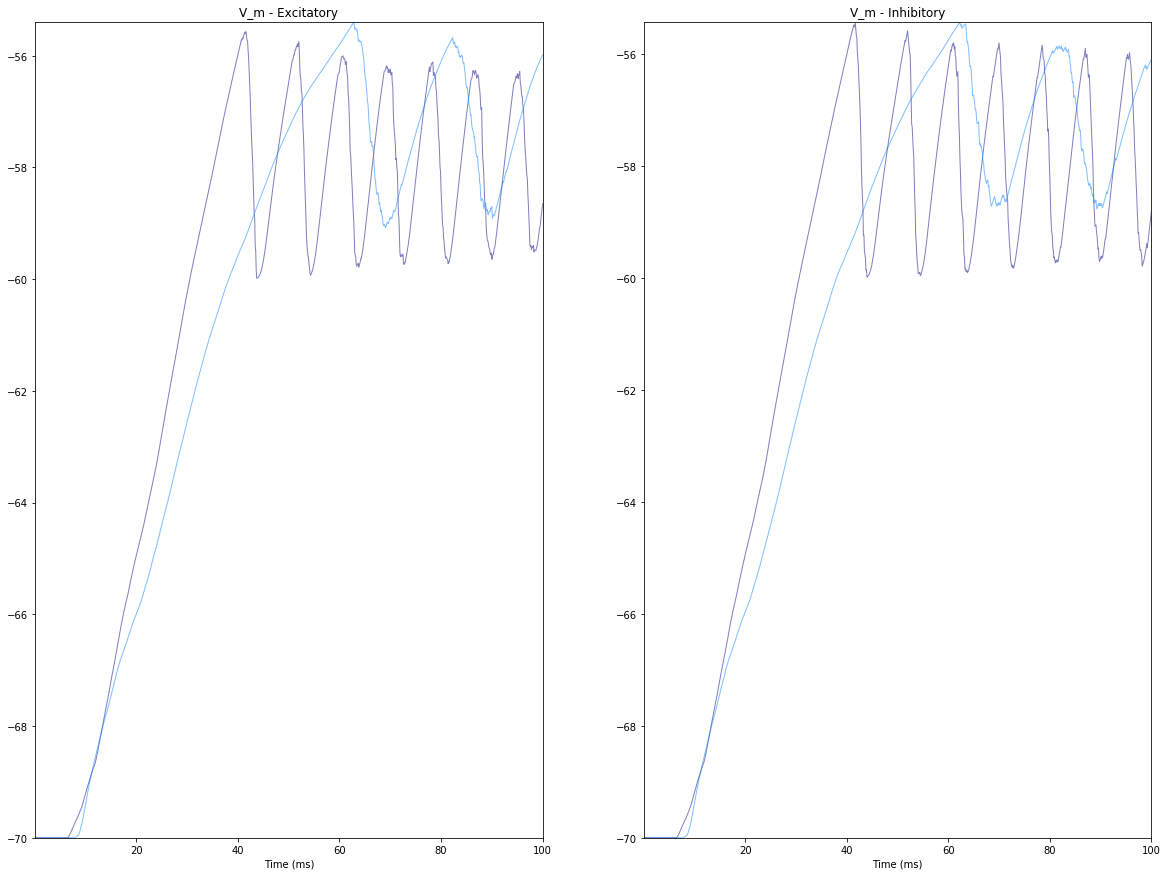

2019-12-02 19:04:51,887 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:51,905 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,002 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,018 - DEBUG - matplotlib.axes._base - update_title_pos


<Figure size 432x288 with 0 Axes>

2019-12-02 19:04:52,040 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,059 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,152 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,165 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,187 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,200 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,215 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,232 - DEBUG - matplotlib.axes._base - update_title_pos


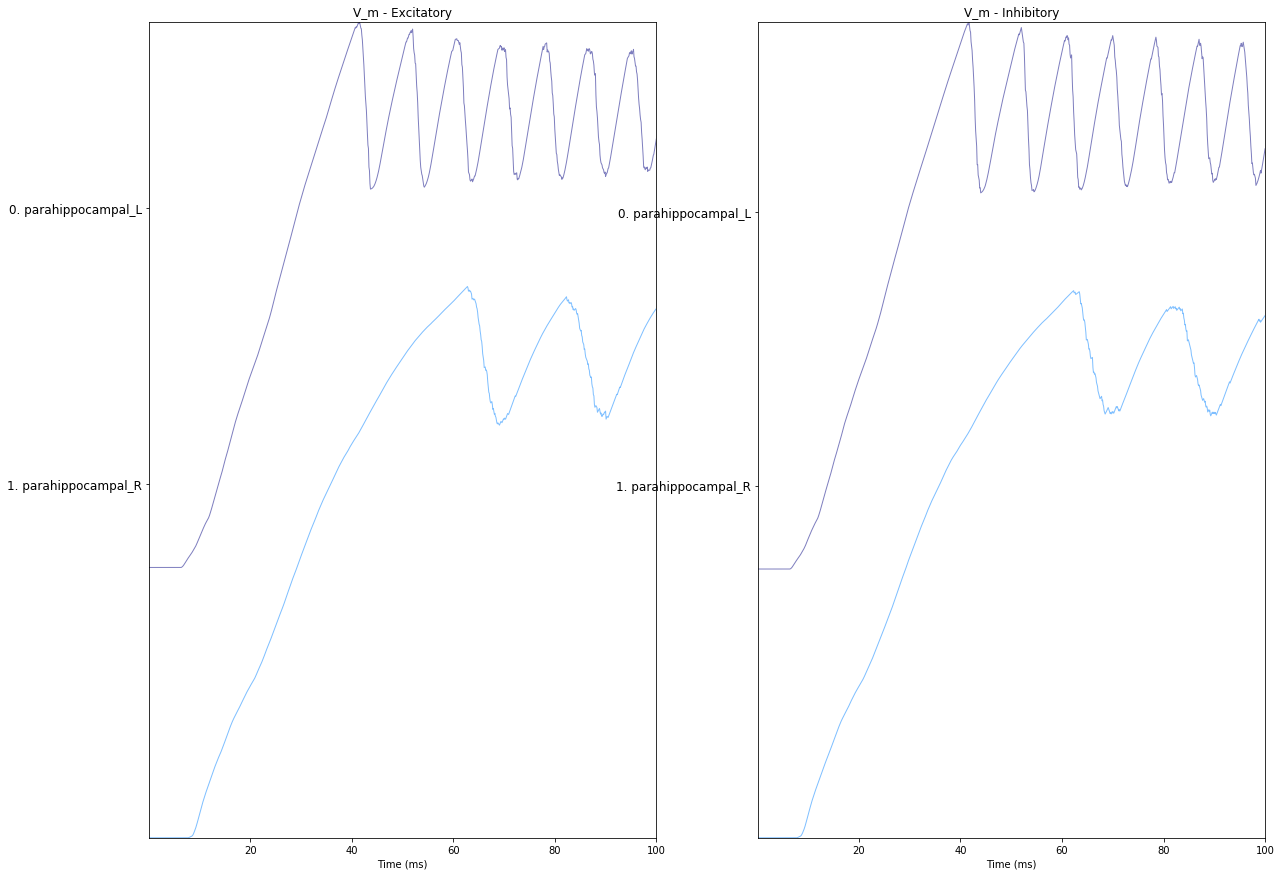

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot NEST multimeter variables
multimeter_mean_data = tvb_nest_model.get_mean_data_from_NEST_multimeter_to_TVBTimeSeries()
if multimeter_mean_data is not None:
    plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                       time_series_class=TimeSeriesRegion, 
                                       time_series_args={}, var_pop_join_str=" - ", 
                                       default_population_label="population",
                                       title="NEST region time series")
    plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                   time_series_class=TimeSeriesRegion, 
                                   time_series_args={}, var_pop_join_str=" - ", 
                                   default_population_label="population",
                                   title="NEST region time series raster")

2019-12-02 19:04:52,513 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,538 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,564 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,581 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,717 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,737 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,759 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,772 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,794 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,811 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,830 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,848 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,950 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:52,982 -

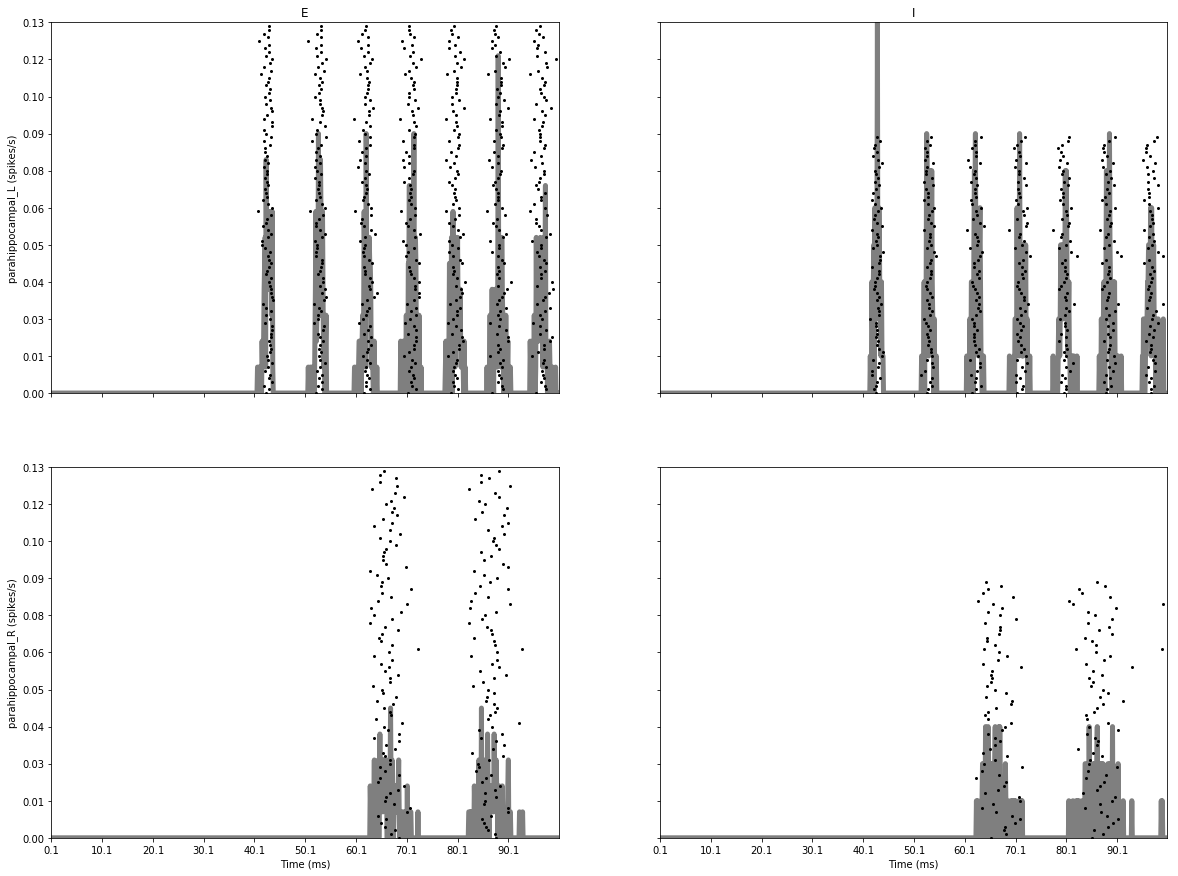

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot spikes and mean field spike rates
rates, spike_detectors = \
    tvb_nest_model.get_mean_spikes_rates_from_NEST_to_TVBTimeSeries(
        spikes_kernel_width=simulator.integrator.dt,  # ms
        spikes_kernel_overlap=0.0, time=t)
if spike_detectors is not None:
    plotter.plot_spikes(spike_detectors, rates=rates, title='Population spikes and mean spike rate')

2019-12-02 19:04:53,694 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:54,159 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:54,289 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:54,617 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:54,664 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:54,699 - DEBUG - matplotlib.axes._base - update_title_pos


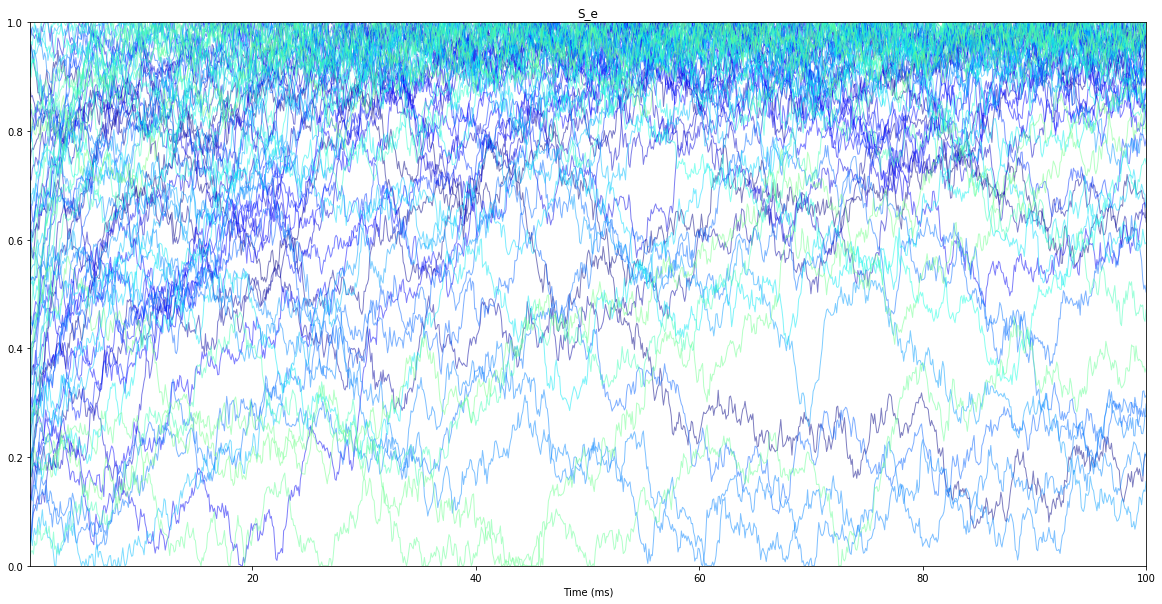

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot timeseries
# Add _tvb from the function names 
# if source_ts is a TVB TimeSeriesRegion object
plotter.plot_timeseries(source_ts.S_e, 
                        title="Excitatory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

2019-12-02 19:04:55,275 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:55,582 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:55,657 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:55,838 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:55,889 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:55,928 - DEBUG - matplotlib.axes._base - update_title_pos


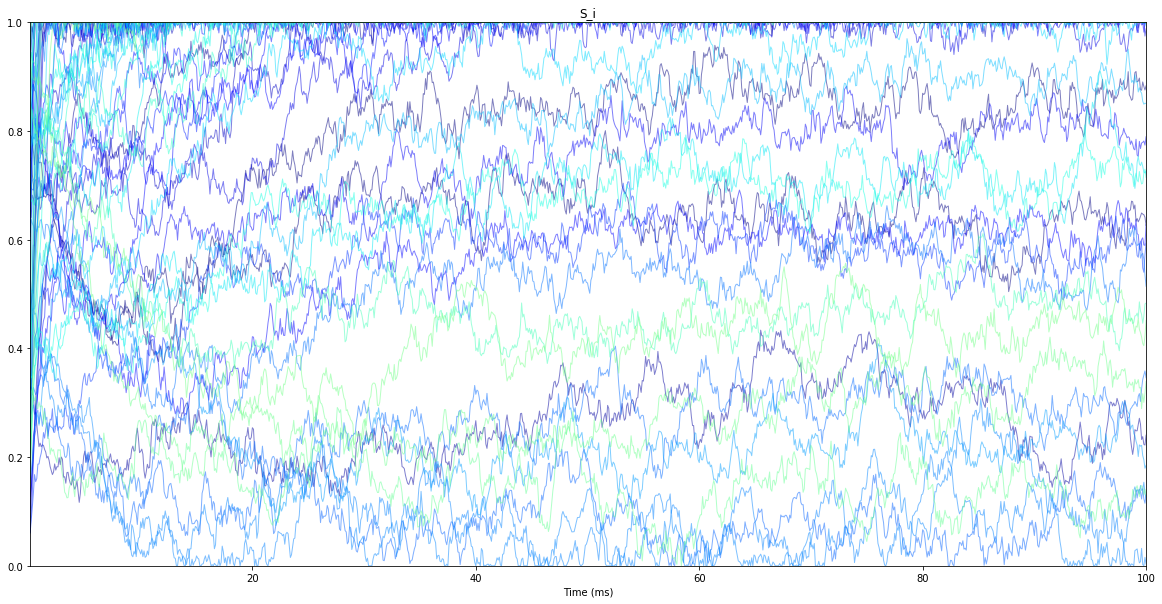

<Figure size 432x288 with 0 Axes>

In [11]:
plotter.plot_timeseries(source_ts.S_i, 
                        title="Inhibitory population time series", 
                        figsize=config.figures.NOTEBOOK_SIZE);

2019-12-02 19:04:56,419 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:56,632 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:56,932 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:57,133 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:57,328 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:57,505 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:57,801 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:57,948 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:58,261 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:58,427 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:58,583 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:58,759 - DEBUG - matplotlib.axes._base - update_title_pos


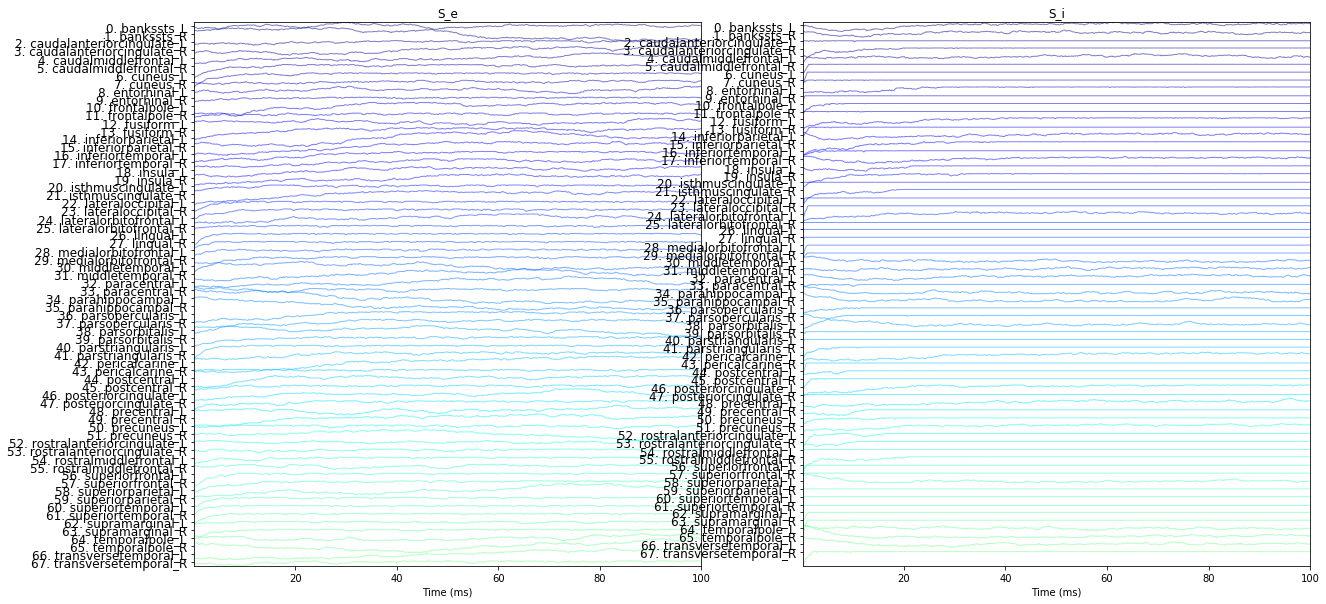

<Figure size 432x288 with 0 Axes>

In [12]:
# For raster plot:
plotter.plot_raster(source_ts, 
                    title="Region Time Series Raster", 
                    figsize=config.figures.NOTEBOOK_SIZE);

### Interactive time series plot

2019-12-02 19:04:59,067 - INFO - tvb_scripts.plot.time_series_interactive_plotter - Generating an interactive time-series plot for TimeSeriesRegion
2019-12-02 19:04:59,067 - INFO - tvb_scripts.plot.time_series_interactive_plotter - Generating an interactive time-series plot for TimeSeriesRegion
2019-12-02 19:04:59,113 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,138 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,140 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,160 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,175 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,176 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,185 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,360 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,549 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:04:59,551 - DEB

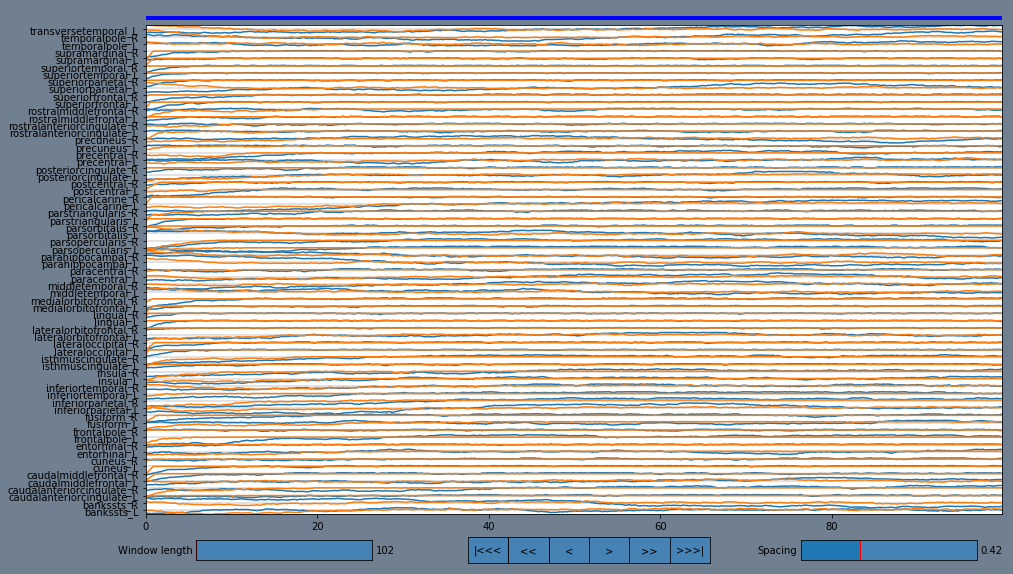

In [13]:
# ...interactively as well
# Use this to skip completely the tvb-scripts plotter
# from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractive
# tvb_plotter = TimeSeriesInteractive(time_series=source_ts._tvb)
# tvb_plotter.configure()
# tvb_plotter.show()
plotter.plot_timeseries_interactive(source_ts)

### Plotting NEST network activity using xarray

2019-12-02 19:05:01,892 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:01,920 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:01,945 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:01,968 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:01,994 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,021 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,068 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,091 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,139 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,164 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,205 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,228 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,265 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,287 -

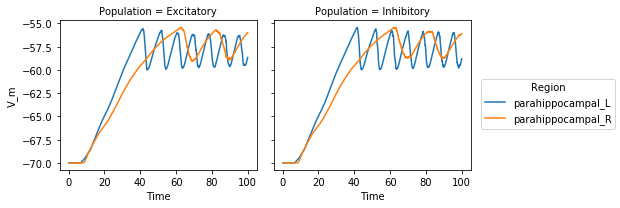

2019-12-02 19:05:02,552 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,624 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,672 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,718 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,754 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:02,773 - DEBUG - matplotlib.axes._base - update_title_pos


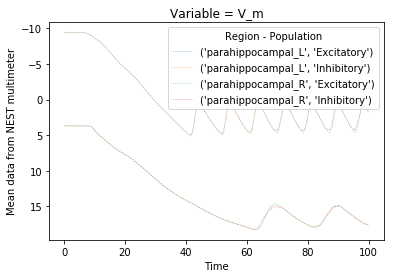

In [14]:
from tvb_scripts.time_series.time_series_xarray import TimeSeries as TimeSeriesXarray
multimeter_mean_data = nest_network.get_mean_data_from_multimeter()
ts = TimeSeriesXarray(multimeter_mean_data)
# ts.plot(plotter=plotter, )
ts.plot_timeseries(plotter=plotter)
ts.plot_raster(plotter=plotter, linestyle="--", alpha=0.5, linewidth=0.5)

### Plotting NEST network spiking activity using xarray

2019-12-02 19:05:03,221 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,254 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,284 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,318 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,357 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a573191d0>
2019-12-02 19:05:03,358 - DEBUG - matplotlib.colorbar - Using auto colorbar locator on colorbar
2019-12-02 19:05:03,359 - DEBUG - matplotlib.colorbar - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6a573191d0>
2019-12-02 19:05:03,360 - DEBUG - matplotlib.colorbar - Setting pcolormesh
2019-12-02 19:05:03,379 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,531 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,676 - DEBUG - matplotlib.axes._base - update_title_pos
2019-12-02 19:05:03,802 - DEBUG - matp

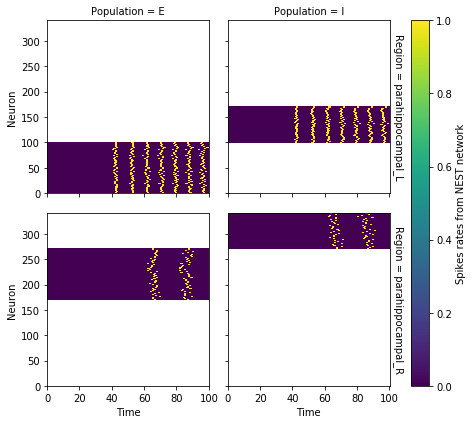

In [15]:
rates = nest_network.compute_spikes_rates(
            mode="per_neuron", population_devices=None, regions=None,
            devices_dim_name="Population", name="Spikes rates from NEST network",
            spikes_kernel_width=None, spikes_kernel_n_intervals=10,
            spikes_kernel_overlap=0.5, min_spike_interval=None, time=t,
            spikes_kernel=None)[0]

rates.plot(x=rates.dims[0], y=rates.dims[3], row=rates.dims[2], col=rates.dims[1], robust=True)
plotter.base._save_figure(figure_name="Spike rates per neuron")

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>
   
3 Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, <br>
  Patric Hagmann and Maurizio Corbetta. <br>
  Resting-State Functional Connectivity Emerges from Structurally and <br>
  Dynamically Shaped Slow Linear Fluctuations. <br>
  The Journal of Neuroscience 32(27), 11239-11252, 2013.<br>

4 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>